In [1]:
%matplotlib inline
import settings
from astropy.time import Time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from lasairmod import LasairError, lasair_client as lasair
import sys, time
import json
import scipy
from sympy import *
from ztfquery import lightcurve, query, metasearch
import scipy.stats as st
from scipy.stats import ks_2samp
from pandas.core.computation.check import NUMEXPR_INSTALLED
import csv
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia

### Defining Functions

In [2]:
def diff_to_app_mag(ref_mag, alert_mag, sign): 
   
    """Function converts from difference magnitudes to apparent magnitudes. 
    
    Parameters
    ----------
    ref_mag : float
        Magnitude of reference source.
    alert_mag : float
        Difference magnitude of alert.
    sign : str
        Sign of the difference magnitude where
        t = positive difference magnitude = brightening
        f = negative difference magnitude = faintening.
        

    Returns
    -------
    app_mag
        Apparent magnitude as type ``float``.
    
    """
    if sign =='t': 
        app_mag = ((-2.5)*log((10**((-.4)*ref_mag)) + (10**((-.4)*alert_mag)),10))
    else:
        app_mag = ((-2.5)*log((10**((-.4)*ref_mag)) - (10**((-.4)*alert_mag)),10)) 
    
    return float(app_mag)

In [3]:
def app_mag_err_prop(ref_mag, alert_mag, sign, ref_err, alert_err):
    
    """Function propagates error when converting from difference magnitudes to apparent magnitudes. 
    
    Parameters
    ----------
    ref_mag : float
        Magnitude of reference source.
    
    alert_mag : float
        Difference magnitude of alert.
    
    sign : str
        Sign of the difference magnitude where
        t = positive difference magnitude = brightening
        f = negative difference magnitude = faintening.
    
    ref_err : float
        1-sigma uncertainty in reference magnitude.
   
    alert_err : float
        1-sigma uncertainty in alert magnitude.
        

    Returns
    -------
    app_err
        Apparent magnitude error as type ``float``.
    
    """
    
    
    r, a= symbols('r a', real=True) # Defines variables r (reference mag) and a (alert mag)
    
    if sign =='t': 
        f = ((-2.5)*log((10**((-.4)*r)) + (10**((-.4)*a)),10))
    else:
        f = ((-2.5)*log((10**((-.4)*r)) - (10**((-.4)*a)),10)) 
    
    
    # f = diff_to_app_mag(ref_mag, alert_mag, sign)
    
    d_ref = diff(f, r).subs([(a, alert_mag), (r, ref_mag)])         # Partial derivative of f with respect to r
    d_alert = diff(f, a).subs([(a, alert_mag), (r, ref_mag)])       # Partial derivative of f with respect to a
    
    app_err = float(sqrt((((d_ref)**2)*((ref_err)**2))+(((d_alert)**2)*((alert_err)**2))))   # Error propagation formula
    
    return app_err

### Query for Disappearing Stars

In [4]:
mjdnow = str(Time.now().mjd)
jdnow = str(Time.now().jd)
days = str(1) # number of days 

selected = '*'


tables = 'objects,sherlock_classifications'


conditions = """
objects.objectId=sherlock_classifications.objectId
AND (objects.sgscore1 > 0.9)
AND (sherlock_classifications.classification != "SN")
AND (sherlock_classifications.classification != "NT")
AND (sherlock_classifications.classification != "AGN")
AND (objects.ncand >= 10)
AND (sherlock_classifications.catalogue_table_name LIKE "%gaia%")
AND (objects.objectId LIKE "ZTF24%")
AND sherlock_classifications.separationArcsec < 0.5
AND ((objects.sgmag1 < 16)
   OR (objects.srmag1 < 16))
AND ISNULL(objects.ncandgp)
AND ("""+jdnow+"""- objects.jdmax) < """+days+"""

"""

L = lasair(settings.API_TOKEN, endpoint = "https://lasair-ztf.lsst.ac.uk/api")

try:
    v4 = L.query(selected, tables, conditions)
except LasairError as e:
    print(e)
    
print('Query returned ' + str(len(v4)) + ' candidates in the past '+ days + ' days')

Query returned 8 candidates in the past 1 days


### Plotting Light Curves from Alert Packet and ZTF archive 

/var/folders/39/_j5zssj14k9d0742tpg79j380000gn/T/ipykernel_15034/2097143381.py:7: DtypeWarning: Columns (0,1,2,3,4,5,10,11,12,13,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path + 'gaia.tsv',comment="#",delimiter=";")


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


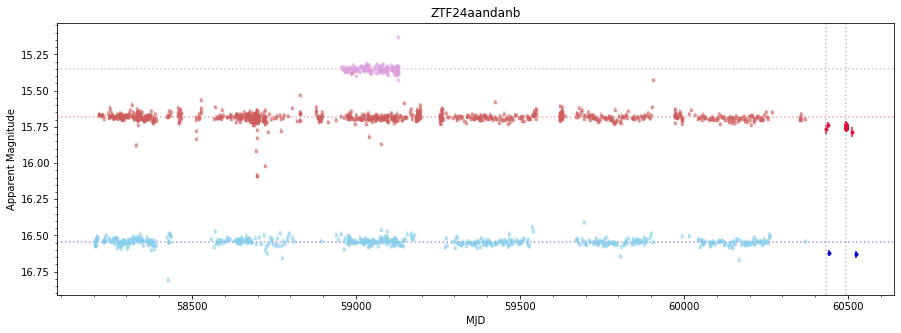

Light curve saved to "/Users/eleanorgallay/Google Drive/SETIsummer/alert_seti/ZTF24aandanbZTF_lightcurve_60524.98862824189.pdf".
ZTF24aandanb g-band KS result: KstestResult(statistic=0.9928443649373881, pvalue=0.01785714285714285, statistic_location=16.6220093, statistic_sign=-1)
ZTF24aandanb r-band KS result: KstestResult(statistic=0.9849424269264836, pvalue=9.006107516485729e-75, statistic_location=15.7331429, statistic_sign=-1)

ZTF24aandanb g-band Chi Square statistic: 2.1387568237744548
ZTF24aandanb g-band 5th - 95th percentile Chi Square statistic: 0.766971117416049
ZTF24aandanb r-band Chi Square statistic: 4.845681292408802
ZTF24aandanb r-band 5th - 95th percentile Chi Square statistic: 0.8844319308269393

ZTF24aandanb has 55 alert packet data points
ZTF24aandanb has 1858 historic data points

INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


<Figure size 432x288 with 0 Axes>

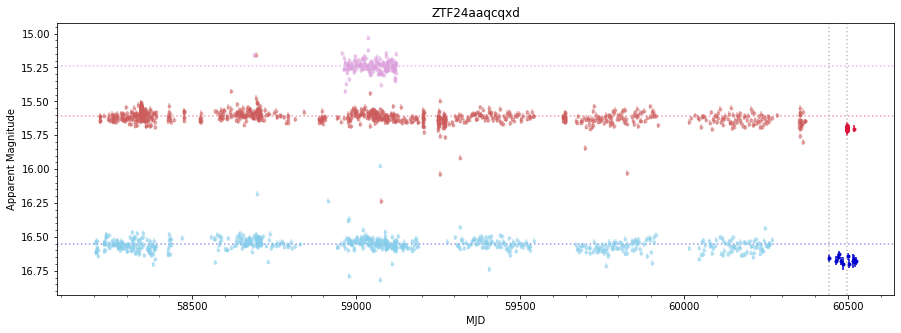

Light curve saved to "/Users/eleanorgallay/Google Drive/SETIsummer/alert_seti/ZTF24aaqcqxdZTF_lightcurve_60524.98862824189.pdf".
ZTF24aaqcqxd g-band KS result: KstestResult(statistic=0.9631811487481591, pvalue=1.1616407904360684e-12, statistic_location=16.6271248, statistic_sign=-1)
ZTF24aaqcqxd r-band KS result: KstestResult(statistic=0.9620018535681186, pvalue=1.640338690048289e-69, statistic_location=15.6767931, statistic_sign=-1)

ZTF24aaqcqxd g-band Chi Square statistic: 7.6295058641044005
ZTF24aaqcqxd g-band 5th - 95th percentile Chi Square statistic: 2.354113278079853
ZTF24aaqcqxd r-band Chi Square statistic: 6.3165813205790595
ZTF24aaqcqxd r-band 5th - 95th percentile Chi Square statistic: 2.423654065062472

ZTF24aaqcqxd has 69 alert packet data points
ZTF24aaqcqxd has 1943 historic data points

INFO: Query finished. [astroquery.utils.tap.core]


<Figure size 432x288 with 0 Axes>

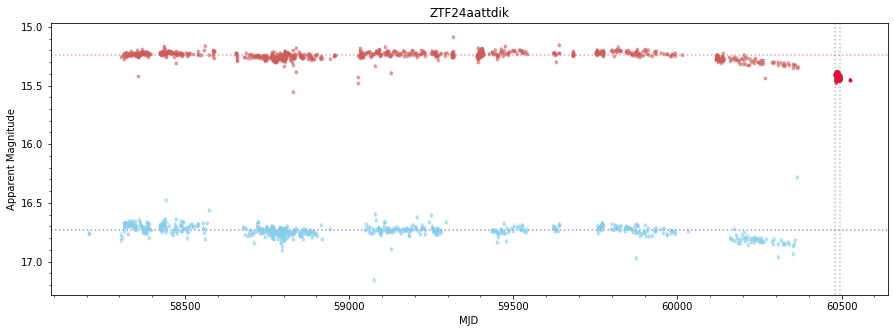

Light curve saved to "/Users/eleanorgallay/Google Drive/SETIsummer/alert_seti/ZTF24aattdikZTF_lightcurve_60524.98862824189.pdf".
ZTF24aattdik r-band KS result: KstestResult(statistic=0.9980601357904947, pvalue=0.0058139534883720825, statistic_location=15.4375849, statistic_sign=-1)

ZTF24aattdik r-band Chi Square statistic: 6.533683334181028
ZTF24aattdik r-band 5th - 95th percentile Chi Square statistic: 2.6250039275334927

ZTF24aattdik has 45 alert packet data points
ZTF24aattdik has 1661 historic data points

INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
5 candidates rejected
3 candidates remain


<Figure size 432x288 with 0 Axes>

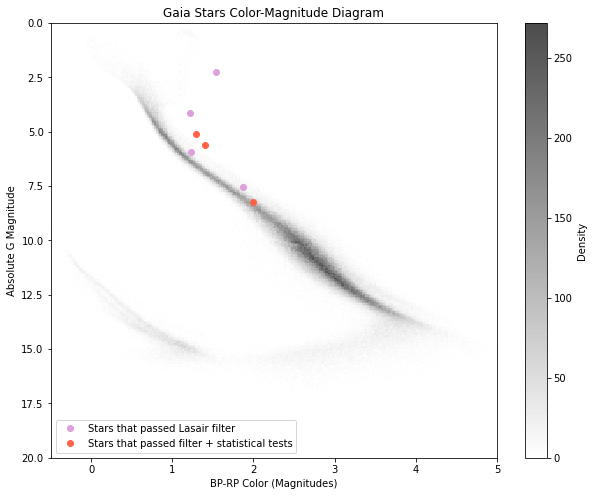

Plot saved to "/Users/eleanorgallay/Google Drive/SETIsummer/alert_seti/CMD.pdf".


<Figure size 432x288 with 0 Axes>

In [9]:
# Pulling info from Gaia catalog of nearby stars

#defining path to folder with my notebook and gaia data
path = '/Users/eleanorgallay/Google Drive/SETIsummer/alert_seti/' 

#reading csv file
df = pd.read_csv(path + 'gaia.tsv',comment="#",delimiter=";")

#dropping empty rows and rows with units rather than numbers
gaia = df.drop([0,1])

#calculating BP-RP color and absolute G magnitude for Gaia catalog of nearby stars

BP = pd.to_numeric(gaia['BPmag'], errors='coerce') #BP magnitude
RP = pd.to_numeric(gaia['RPmag'], errors='coerce') #RP magnitude
color = BP - RP #BP-RP color
gaia_gmag = pd.to_numeric(gaia['Gmag'], errors='coerce') #apparent g magnitudes
plx = pd.to_numeric(gaia['Plx'], errors= 'coerce')/1000 #parallax in arcsec
d = 1/plx #distance in parsecs
gaia_GMAG = gaia_gmag - 5*(np.log10(d/10)) #absolute g magnitudes using distance modulus and parallax


# Pulling alert packets from stars that passed Lasair filter

Dips= L.objects([row['objectId'] for row in v4])
lc = {}
candidates = []
trash = []
cand_color = []
trash_color = []
cand_gmag = []
trash_gmag = []

broker = path+ 'statistics_' + mjdnow+ '.csv'
headers = ["Object", "g_X2", "r_X2", "i_X2", "g_5-95_X2", "r_5-95_X2", "i_5-95_X2", "g_KSpvalue", "r_KSpvalue", "i_KSpvalue"]

with open(broker, 'w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=headers)
    writer.writeheader()

for obj in Dips:
    try:
        lc[obj['objectId']] = {'candidates': obj['candidates']}
    except TypeError:
        print('no')
    
    # Creating dictionary of variables
    variables = {}
    
    # Pulling historic ZTF light curve
    ztf = lightcurve.LCQuery.from_position(obj['objectData']['ramean'], obj['objectData']['decmean'], 1)
        
    # Defining arrays of ZTF historic magnitudes for each filter
    ztf_gsamp = np.array(ztf.data['mag'][ztf.data['filtercode'] == 'zg'][ztf.data['mjd'] < obj['objectData']['discMjd']][ztf.data['magerr'] > 0])
    ztf_rsamp = np.array(ztf.data['mag'][ztf.data['filtercode'] == 'zr'][ztf.data['mjd'] < obj['objectData']['discMjd']][ztf.data['magerr'] > 0])
    ztf_isamp = np.array(ztf.data['mag'][ztf.data['filtercode'] == 'zi'][ztf.data['mjd'] < obj['objectData']['discMjd']][ztf.data['magerr'] > 0])
    
    # same for magnitude errors
    ztf_gerr = np.array(ztf.data['magerr'][ztf.data['filtercode'] == 'zg'][ztf.data['mjd'] < obj['objectData']['discMjd']][ztf.data['magerr'] > 0])
    ztf_rerr = np.array(ztf.data['magerr'][ztf.data['filtercode'] == 'zr'][ztf.data['mjd'] < obj['objectData']['discMjd']][ztf.data['magerr'] > 0])
    ztf_ierr = np.array(ztf.data['magerr'][ztf.data['filtercode'] == 'zi'][ztf.data['mjd'] < obj['objectData']['discMjd']][ztf.data['magerr'] > 0])
    
    # ...and dates
    ztf_gmjd = np.array(ztf.data['mjd'][ztf.data['filtercode'] == 'zg'][ztf.data['mjd'] < obj['objectData']['discMjd']][ztf.data['magerr'] > 0])
    ztf_rmjd = np.array(ztf.data['mjd'][ztf.data['filtercode'] == 'zr'][ztf.data['mjd'] < obj['objectData']['discMjd']][ztf.data['magerr'] > 0])
    ztf_imjd = np.array(ztf.data['mjd'][ztf.data['filtercode'] == 'zi'][ztf.data['mjd'] < obj['objectData']['discMjd']][ztf.data['magerr'] > 0])
    
    # calculating 5th - 95th percentile ranges for historic data 
    if len(ztf_gsamp) > 0:
        variables['ghist'] = ztf_gsamp[(obj['objectData']['discMjd'] - ztf_gmjd) > 100] # restricting data to 100 days before discovery date
        variables['ghisterr'] = ztf_gerr[(obj['objectData']['discMjd'] - ztf_gmjd) > 100]
        variables['g_p5'] = np.percentile(variables['ghist'], 5)
        variables['g_p95'] = np.percentile(variables['ghist'], 95)
        variables['g_5to95'] = variables['ghist'][(variables['ghist'] > variables['g_p5']) & (variables['ghist'] < variables['g_p95'])]
        variables['gerr_5to95'] = variables['ghisterr'][(variables['ghist'] > variables['g_p5']) & (variables['ghist'] < variables['g_p95'])]
    
    if len(ztf_rsamp) > 0:
        variables['rhist'] = ztf_rsamp[(obj['objectData']['discMjd'] - ztf_rmjd) > 100] # restricting data to 100 days before discovery date
        variables['rhisterr'] = ztf_rerr[(obj['objectData']['discMjd'] - ztf_rmjd) > 100]
        variables['r_p5'] = np.percentile(variables['rhist'], 5)
        variables['r_p95'] = np.percentile(variables['rhist'], 95)
        variables['r_5to95'] = variables['rhist'][(variables['rhist'] > variables['r_p5']) & (variables['rhist'] < variables['r_p95'])]
        variables['rerr_5to95'] = variables['rhisterr'][(variables['rhist'] > variables['r_p5']) & (variables['rhist'] < variables['r_p95'])]
    
    if len(ztf_isamp) > 0:
        variables['ihist'] = ztf_isamp[(obj['objectData']['discMjd'] - ztf_imjd) > 100] # restricting data to 100 days before discovery date
        variables['ihisterr'] = ztf_ierr[(obj['objectData']['discMjd'] - ztf_imjd) > 100]
        variables['i_p5'] = np.percentile(variables['ihist'], 5)
        variables['i_p95'] = np.percentile(variables['ihist'], 95)
        variables['i_5to95'] = variables['ihist'][(variables['ihist'] > variables['i_p5']) & (variables['ihist'] < variables['i_p95'])]
        variables['ierr_5to95'] = variables['ihisterr'][(variables['ihist'] > variables['i_p5']) & (variables['ihist'] < variables['i_p95'])]
    
    # Creating empty lists for each ZTF filter-band to be filled with apparent magnitudes and errors from alert packet
    gmag = []
    rmag = []
    imag = []
    
    gerr = []
    rerr = []
    ierr = []
    
    gmjd = []
    rmjd = []
    imjd = []
    alertmjd = []
    
    for alert in lc[obj['objectId']]['candidates']:
        if 'isdiffpos' in alert:
            alertmjd.append(alert['mjd'])
            
            # appending magnitudes and errors in each filter to their respective lists
            if alert['fid']== 1:
                variables['app_gmag'] = diff_to_app_mag(np.median(variables['ghist']), alert['magpsf'], alert['isdiffpos']) # calculating apparent magnitude 
                variables['app_gerr'] = app_mag_err_prop(np.median(variables['ghist']), alert['magpsf'], alert['isdiffpos'], np.median(variables['ghisterr']), alert['sigmapsf']) # propagating error      
                gmag.append(variables['app_gmag'])
                gerr.append(variables['app_gerr'])
                gmjd.append(alert['mjd'])
            
            if alert['fid']== 2:
                variables['app_rmag'] = diff_to_app_mag(np.median(variables['rhist']), alert['magpsf'], alert['isdiffpos']) # calculating apparent magnitude 
                variables['app_rerr'] = app_mag_err_prop(np.median(variables['rhist']), alert['magpsf'], alert['isdiffpos'], np.median(variables['rhisterr']), alert['sigmapsf']) # propagating error
                rmag.append(variables['app_rmag'])
                rerr.append(variables['app_rerr'])
                rmjd.append(alert['mjd'])
            
            if alert['fid']== 3:
                variables['app_imag'] = diff_to_app_mag(np.median(variables['ihist']), alert['magpsf'], alert['isdiffpos']) # calculating apparent magnitude 
                variables['app_ierr'] = app_mag_err_prop(np.median(variables['ihist']), alert['magpsf'], alert['isdiffpos'], np.median(variables['ihisterr']), alert['sigmapsf']) # propagating error
                imag.append(variables['app_imag'])
                ierr.append(variables['app_ierr'])
                imjd.append(alert['mjd'])
    
    
    # Restricting alert epoch magnitudes to data observed at least 30 days after the discovery date in Lasair
    alert_gsamp = np.array(gmag)[(np.array(gmjd) - obj['objectData']['discMjd']) >= 30]
    alert_rsamp = np.array(rmag)[(np.array(rmjd) - obj['objectData']['discMjd']) >= 30]
    alert_isamp = np.array(imag)[(np.array(imjd) - obj['objectData']['discMjd']) >= 30]
    
    # Performing K-S test with 95% confidence interval and calculating chi square statistic for each filter
    if len(alert_gsamp) > 0 and len(variables['ghist']) > 0:
        variables['KS_g'] = st.ks_2samp(alert_gsamp, variables['ghist'])
        variables['g_pvalue'] = variables['KS_g'].pvalue
        variables['chisq_g'] = np.sum((((variables['ghist'] - np.median(variables['ghist'])) / variables['ghisterr'])**2 ) / float(len(variables['ghist'])))
        variables['chisq_g_5to95'] = np.sum((((variables['g_5to95'] - np.median(variables['g_5to95'])) / variables['gerr_5to95'])**2 ) / float(len(variables['g_5to95'])))
            
    if len(alert_rsamp) > 0 and len(variables['rhist']) > 0:  
        variables['KS_r'] = st.ks_2samp(alert_rsamp, variables['rhist'])
        variables['r_pvalue'] = variables['KS_r'].pvalue
        variables['chisq_r'] = np.sum((((variables['rhist'] - np.median(variables['rhist'])) / variables['rhisterr'])**2 ) / float(len(variables['rhist'])))
        variables['chisq_r_5to95'] = np.sum((((variables['r_5to95'] - np.median(variables['r_5to95'])) / variables['rerr_5to95'])**2 ) / float(len(variables['r_5to95'])))

    if len(alert_isamp) > 0 and len(variables['ihist']) > 0: 
        variables['KS_i'] = st.ks_2samp(alert_isamp, variables['ihist'])
        variables['i_pvalue'] = variables['KS_i'].pvalue
        variables['chisq_i'] = np.sum((((variables['ihist'] - np.median(variables['ihist'])) / variables['ihisterr'])**2 ) / float(len(variables['ihist'])))
        variables['chisq_i_5to95'] = np.sum((((variables['i_5to95'] - np.median(variables['i_5to95'])) / variables['ierr_5to95'])**2 ) / float(len(variables['i_5to95'])))
           
   
    # Imposing conditions that K-S test p-value is < 0.05 (95% confidence interval) and Chi square statistic is < 50
    g = True
    r = True
    i = True

    # if g true then there are alert samples, at least a hundred historic samples, and they meet the stats
    if len(gmag) > 0:
        g = False
        if len(alert_gsamp) > 0 and len(variables['ghist']) >= 100:
            g = (variables['KS_g'].pvalue < 0.05) and (np.median(alert_gsamp) > variables['g_p95']) and (variables['chisq_g'] < 15) and (variables['chisq_g_5to95'] < 5) 
    
    if len(rmag) > 0:
        r = False
        if len(alert_rsamp) > 0 and len(variables['rhist']) >= 100:
            r = (variables['KS_r'].pvalue < 0.05) and (np.median(alert_rsamp) > variables['r_p95']) and (variables['chisq_r'] < 15) and (variables['chisq_r_5to95'] < 5) 
            
    if len(imag) > 0:
        i = False
        if len(alert_isamp) > 0 and len(variables['ihist']) >= 100:
             i = (variables['KS_i'].pvalue < 0.05) and (np.median(alert_isamp) > variables['i_p95']) and (variables['chisq_i'] < 15) and (variables['chisq_i_5to95'] < 5) 
        
    if g and r and i:
        
        
        
        candidates.append(obj['objectId'])
        
        cand_coord = SkyCoord(ra=obj['objectData']['ramean'], dec=obj['objectData']['decmean'], unit=(u.degree, u.degree), frame='icrs')
        cand_search = Gaia.cone_search_async(cand_coord, radius=u.Quantity(1.0, u.arcsec))
        cand_match = cand_search.get_data()
        cand_plx = float(cand_match['parallax']) # in milliarcseconds
        cand_bp_rp= float(cand_match['bp_rp']) # BP - RP color in magnitudes
        cand_g_appmag = float(cand_match['phot_g_mean_mag']) # apparent g-bang magnitude
        cand_GMAG = cand_g_appmag - 5*np.log10(1000/cand_plx) + 5 # calculating absolute magnitude
        
        cand_color.append(cand_bp_rp)
        cand_gmag.append(cand_GMAG)
        
        
        
        statistics_list = [
            {"Object": obj['objectId']}, 
            {"g_X2": variables.get('chisq_g', np.nan)}, 
            {"r_X2": variables.get('chisq_r', np.nan)},
            {"i_X2": variables.get('chisq_i', np.nan)},
            {"g_5-95_X2": variables.get('chisq_g_5to95', np.nan)},
            {"r_5-95_X2": variables.get('chisq_r_5to95', np.nan)},
            {"i_5-95_X2": variables.get('chisq_i_5to95', np.nan)},
            {"g_KSpvalue": variables.get('g_pvalue', np.nan)},
            {"r_KSpvalue": variables.get('r_pvalue', np.nan)},
            {"i_KSpvalue": variables.get('i_pvalue', np.nan)},
        ]
        
        with open(broker, 'a', newline='') as file:
            writer = csv.DictWriter(file, fieldnames=headers)
            for stats in statistics_list:
                writer.writerow(stats)
             
             
      
        
        # Plotting
        plt.figure(figsize = (15, 5))
        plt.subplot(111)
        
        figname = path+ str(obj['objectId'])+ 'ZTF_lightcurve_' + mjdnow +'.pdf'
        
        ga = plt.errorbar(gmjd, gmag, yerr = gerr, fmt = '.', color= 'mediumblue', label = 'g (alert)')
        ra = plt.errorbar(rmjd, rmag, yerr = rerr, fmt = '.', color= 'crimson', label = 'r (alert)')
        ia = plt.errorbar(imjd, imag, yerr = ierr, fmt = '.', color= 'mediumorchid', label = 'i (alert)')

        gh = plt.errorbar(ztf_gmjd, ztf_gsamp, yerr = ztf_gerr, fmt = '.', color= 'skyblue', alpha = 0.4, label = 'g (historic)')
        rh = plt.errorbar(ztf_rmjd, ztf_rsamp, yerr = ztf_rerr, fmt = '.', color= 'indianred', alpha = 0.4, label = 'r (historic)')
        ih = plt.errorbar(ztf_imjd, ztf_isamp, yerr = ztf_ierr, fmt = '.', color= 'plum', alpha = 0.4, label = 'i (historic)')
        
        ymin, ymax = plt.gca().get_ylim()
        xmin, xmax = plt.gca().get_xlim()
        
        mjdmin = plt.vlines(obj['objectData']['jdmin']-2400000.5, ymin, ymax, color='silver', linestyles=':', label='mjd min')  
        disc = plt.vlines(obj['objectData']['discMjd'], ymin, ymax, color='silver', linestyles=':', label='disc date')
        
        if 'ghist' in variables:
            gmed = plt.hlines(np.median(variables['ghist']), xmin, xmax, color='mediumblue', alpha= 0.4, linestyles=':', label='historic g-band median magnitude')
        
        if 'rhist' in variables:
            rmed = plt.hlines(np.median(variables['rhist']), xmin, xmax, color='crimson', alpha= 0.4, linestyles=':', label='historic g-band median magnitude')
        
        if 'ihist' in variables:
            imed = plt.hlines(np.median(variables['ihist']), xmin, xmax, color='mediumorchid', alpha= 0.4, linestyles=':', label='historic g-band median magnitude')
        
        plt.xlim(xmin, xmax)
        plt.ylim(ymin, ymax)
        plt.minorticks_on()
        plt.gca().invert_yaxis()
        plt.ylabel('Apparent Magnitude')
        plt.xlabel('MJD')
        plt.title(obj['objectId'])
        plt.show()
        
        plt.savefig(figname, format='pdf', dpi=300, bbox_inches='tight', pad_inches=0)
        print ('Light curve saved to \"'+figname+'\".')
        
        # Printing K-S test results
        if 'KS_g' in variables:
            print(obj['objectId']+' g-band KS result: '+ str(variables['KS_g']))
            

        if 'KS_r' in variables:  
            print(obj['objectId']+' r-band KS result: '+ str(variables['KS_r']))
            
            
        if 'KS_i' in variables: 
            print(obj['objectId']+' i-band KS result: '+ str(variables['KS_i']))
            
            
        print()

        # Printing Chi Square test results
        if 'chisq_g' in variables:
            print(obj['objectId']+' g-band Chi Square statistic: '+ str(variables['chisq_g']))
            print(obj['objectId']+' g-band 5th - 95th percentile Chi Square statistic: '+ str(variables['chisq_g_5to95']))

        if 'chisq_r' in variables:  
            print(obj['objectId']+' r-band Chi Square statistic: '+ str(variables['chisq_r']))
            print(obj['objectId']+' r-band 5th - 95th percentile Chi Square statistic: '+ str(variables['chisq_r_5to95']))

        if 'chisq_i' in variables: 
            print(obj['objectId']+' i-band Chi Square statistic: '+ str(variables['chisq_i']))
            print(obj['objectId']+' i-band 5th - 95th percentile Chi Square statistic: '+ str(variables['chisq_i_5to95']))

        print() 
        
        print(obj['objectId']+' has '+ str(len(gmag) + len(rmag) + len(imag))+ ' alert packet data points')
        print(obj['objectId']+' has '+ str(len(ztf.data['mag']))+ ' historic data points')
        
        print ()
        
    else:
        trash.append(obj['objectId'])
        trash_coord = SkyCoord(ra=obj['objectData']['ramean'], dec=obj['objectData']['decmean'], unit=(u.degree, u.degree), frame='icrs')
        trash_search = Gaia.cone_search_async(trash_coord, radius=u.Quantity(1.0, u.arcsec))
        trash_match = trash_search.get_data()
        trash_plx = float(trash_match['parallax']) # in milliarcseconds
        trash_bp_rp= float(trash_match['bp_rp']) # BP - RP color in magnitudes
        trash_g_appmag = float(trash_match['phot_g_mean_mag']) # apparent g-bang magnitude
        trash_GMAG = trash_g_appmag - 5*np.log10(1000/trash_plx) + 5 # calculating absolute magnitude
        
        trash_color.append(trash_bp_rp)
        trash_gmag.append(trash_GMAG)
        
    variables.clear()
   
print(str(len(trash)) + ' candidates rejected')
print(str(len(candidates)) + ' candidates remain') 

CMD = path + 'CMD.pdf'

plt.figure(figsize=(10, 8))
plt.hist2d(color, gaia_GMAG, bins=[300,300], cmap='binary', alpha = 0.7, range=[[-1, 5.5], [-2, 20]])

plt.plot(trash_color, trash_gmag, 'o', color = 'plum', zorder= 10, label = 'Stars that passed Lasair filter')
plt.plot(cand_color, cand_gmag, 'o', color = 'tomato', zorder= 11, label = 'Stars that passed filter + statistical tests')
plt.legend()
plt.colorbar(label='Density')
plt.xlabel('BP-RP Color (Magnitudes)')
plt.ylabel('Absolute G Magnitude')
plt.xlim(-.5, 5)
plt.ylim(20, 0)
plt.title('Gaia Stars Color-Magnitude Diagram')
plt.show()

plt.savefig(CMD, format='pdf', dpi=300, bbox_inches='tight', pad_inches=0)
print ('Plot saved to \"'+CMD+'\".')

Current criteria

Lasair query criteria:
- objects.sgscore1 > 0.9 (closer to 1 means the object is more likely to be a star than a galaxy)
- Object is not classified as a supernova, nuclear transient, nor active galactic nucleus by the sherlock classification scheme in Lasair
- Object has at least 10 data points in its alert packet
- Object has been crossmatched with the Gaia catalog
- Object is within 0.5 arcseconds of the best source match from sherlock
- Closest source match object is brighter than 16th magnitude in either g or r band
- Alert magnitudes are all fainter than the reference magnitude
- Alert occurred within the past 1 day
- Object's first alert happened in 2024

Further criteria:
- If object has alert data from a given filter, it must have at least 100 data points in its historic light curve from ZTF for that filter
- Object passes two-sample K-S test with a p-value less than 0.05 in every filter
- Object's historic data has a chi-square statistic less than 15
- Object's historic data that falls within the 5th to 95th percentile range has chi-square statistic less than 5
- Object's median alert magnitude is greater/fainter than the 95th percentile magnitude of the historic data in every filter

Note: K-S and chi square tests are calculated on historic data from over 100 days before the alert epoch and alert data from at least 30 days after the discovery date in Lasair

In [ ]:
# This could be added plot rejected candidates
#         if not (len(alert_gsamp) == 0 or len(ztf_gsamp) == 0 or KS_g.pvalue < 0.05):
#             print('failed g K-S test')
#         if not (len(alert_rsamp) == 0 or len(ztf_rsamp) == 0 or KS_r.pvalue < 0.05):
#             print('failed r K-S test')
#         if not (len(alert_isamp) == 0 or len(ztf_isamp) == 0 or KS_i.pvalue < 0.05):
#             print('failed i K-S test')
#         if not (len(alert_gsamp) == 0 or len(ztf_gsamp) == 0 or chisq_g < 50):
#             print('failed g Chi square test')
#         if not (len(alert_rsamp) == 0 or len(ztf_rsamp) == 0 or chisq_r < 50):
#             print('failed r Chi square test')
#         if not (len(alert_isamp) == 0 or len(ztf_isamp) == 0 or chisq_i < 50):
#             print('failed i Chi square test')     

#         # Plotting
#         plt.figure(figsize = (15, 5))
#         plt.subplot(111)

#         ga = plt.errorbar(gmjd, gmag, yerr = gerr, fmt = '.', color= 'darkgreen', label = 'g (alert)')
#         ra = plt.errorbar(rmjd, rmag, yerr = rerr, fmt = '.', color= 'red', label = 'r (alert)')
#         ia = plt.errorbar(imjd, imag, yerr = ierr, fmt = '.', color= 'indigo', label = 'i (alert)')

#         gh = plt.errorbar(ztf_gmjd, ztf_gsamp, yerr = ztf_gerr, fmt = '.', color= 'lightgreen', label = 'g (historic)')
#         rh = plt.errorbar(ztf_rmjd, ztf_rsamp, yerr = ztf_rerr, fmt = '.', color= 'lightcoral', label = 'r (historic)')
#         ih = plt.errorbar(ztf_imjd, ztf_isamp, yerr = ztf_ierr, fmt = '.', color= 'slateblue', label = 'i (historic)')

#         mjdmin = plt.vlines(obj['objectData']['jdmin']-2400000.5, *plt.gca().get_ylim(), color='lightgray', label='mjd min')  
#         disc = plt.vlines(obj['objectData']['discMjd'], *plt.gca().get_ylim(), color='lavender', label='disc date')
#         plt.gca().invert_yaxis()
#         plt.legend([gh, rh, ih, ga, ra, ia, disc, mjdmin], ['g (historic)', 'r (historic)', 'i (historic)', 'g (alert)', 'r (alert)', 'i (alert)', 'disc date', 'mjd min'], loc='upper left', ncol=3)
#         plt.ylabel('Apparent Magnitude')
#         plt.xlabel('mjd')
#         plt.title(obj['objectId'])
#         plt.show()

#         # Printing K-S test results
#         if len(alert_gsamp) > 0 and len(ztf_gsamp) > 0:
#             print(obj['objectId']+' g-band KS result: '+ str(KS_g))

#         if len(alert_rsamp) > 0 and len(ztf_rsamp) > 0:  
#             print(obj['objectId']+' r-band KS result: '+ str(KS_r))

#         if len(alert_isamp) > 0 and len(ztf_isamp) > 0: 
#             print(obj['objectId']+' i-band KS result: '+ str(KS_i))

#         print()

#         # Printing Chi Square test results
#         if len(alert_gsamp) > 0 and len(ztf_gsamp) > 0:
#             print(obj['objectId']+' g-band Chi Square statistic: '+ str(chisq_g))
#             #print(obj['objectId']+' g-band Chi Square critical value: '+ str(crit_g))

#         if len(alert_rsamp) > 0 and len(ztf_rsamp) > 0:  
#             print(obj['objectId']+' r-band Chi Square statistic: '+ str(chisq_r))
#             #print(obj['objectId']+' r-band Chi Square critical value: '+ str(crit_r))

#         if len(alert_isamp) > 0 and len(ztf_isamp) > 0: 
#             print(obj['objectId']+' i-band Chi Square statistic: '+ str(chisq_i))
#             #print(obj['objectId']+' i-band Chi Square critical value: '+ str(crit_i))

#         print() 